In [3]:
%config InlineBackend.figure_format = 'svg'
import os
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import io, data, filters
from skimage.viewer import ImageViewer
from skimage.exposure import histogram
from skimage.measure import label
from skimage.segmentation import flood, flood_fill
from scipy import ndimage
from scipy.ndimage.measurements import label
from functools import reduce
from PIL import Image
import cv2

from skimage.transform import rotate, rescale


# https://www.youtube.com/watch?v=TyWtx7q2D7Y
# Connected componenets

def scale_down(img, scalar):
    dims = img.shape
    height, length = dims[0], dims[1]
    return (length/scalar, height/scalar)
#     return rescale(img, scalar)

def show(img, scalar=1):
    if scalar:
        plt.figure(figsize = scale_down(img, scalar))
    else:
        plt.figure()
    io.imshow(img, aspect='auto')
    io.show()

def centroid(t1,t2):
    return (int(sum(t1)/2), int(sum(t2)/2))

# Todo refactor to check set of sets for largest then retrieve row
def unique(array, ignore=[0]):
    ignore = set(ignore)
    seen = set()
    u = []
    for a in array:
        if a not in seen and a not in ignore:
            seen.add(a)
            u.append(a)
    return u
            
def get_label_sets(labeled):
    # loop through rows
    # later allow for cols/groups
    label_sets = set()
    order_rows = []
    for row in labeled:
        clean_row = unique(row)
        frozen = frozenset(clean_row)
        if frozen not in label_sets:
            label_sets.add(frozen)
            if clean_row:
                order_rows.append({'length':len(clean_row), 'row': clean_row})
    return order_rows

def get_label_hist(labeled):
    row_label_sets = get_label_sets(labeled)
    x_vals = range(len(row_label_sets))
    y_vals = [y['length'] for y in row_label_sets]

    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(x_vals,y_vals)
    plt.show()
    
def filter_bounds(bounds):
    bound_nums = []
    p1 = 0
    for p2 in range(1,len(bounds)):
        if bounds[p2]-1 == bounds[p2-1]:
            p2 += 1
        else:
            p1 = p2-1
            bound_nums.append((bounds[p1],bounds[p2]))
        
    return bound_nums
        
def get_bounds(int_img):
    return [i for i, row in enumerate(int_img) if not sum(row)]
#     bounds = []
#     for i, row in enumerate(int_img):            
#         if not sum(row):
#             bounds.append(i)
#     return bounds

def get_chunk(tup, labeled):
    i, j = tup
    return [unique(r) for r in labeled[i+1:j]]

def get_chunk_set(chunk):
    chunk_sets = list(map(set, chunk))
    return reduce(lambda a,b: a.union(b), chunk_sets)

def get_labeled_for_rows(labeled, row_tups):
    sprite_rows = []
    for tup in row_tups:
        max_row = []
        chunk = get_chunk(tup, labeled)
        chunk_set = get_chunk_set(chunk)
        sorted_rows = sorted(chunk, key=lambda x: len(x), reverse=True)
        if not sorted_rows:
            continue
        while set(max_row) != chunk_set:
            extra = sorted_rows.pop(0)
            max_row.extend(extra)
        sprite_rows.append(unique(max_row))
    return sprite_rows


def transpose(img_array):
    return np.array([list(i) for i in zip(*img)])

(256, 576, 4)
<class 'numpy.ndarray'>


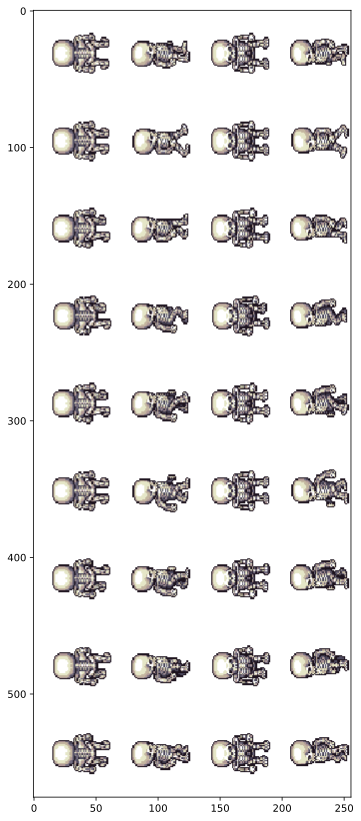

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
<class 'numpy.ndarray'> (576, 256)
<class 'numpy.ndarray'> (576, 256)
-----
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322,

In [20]:
img = io.imread('samples/skelly.png')
print(img.shape)
print(type(img))
# timg = np.array([list(i) for i in zip(*img)])
# print(timg.shape)

img = transpose(img)
background = flood(img[..., 0], (0,0), tolerance=0.0)
img[background] = 0
#img = img * ~background
show(img, 50)
intback = np.invert(background).astype(int)
print(intback)
print(type(intback), intback.shape)
#intback = intback.T
print(type(intback), intback.shape)
print('-----')
print(get_bounds(intback))

In [5]:
from skimage.color import label2rgb

structure = np.ones((3, 3), dtype=np.int)
labeled, ncomponents = label(intback, structure)
# label_img = label2rgb(labeled, image=img, bg_label=0)
# label_img = rotate(label_img[:, ::-1], 90, resize=True)
# print(img.shape)
# print(label_img.shape)
# show(label_img,50)

In [6]:
#show(intback,50)
#show(img[0:50,0:50],50)

bound_tups = filter_bounds(get_bounds(intback))
labeled_sprites = get_labeled_for_rows(labeled, bound_tups)
# print('----')
# n = 0
# for r in labeled_sprites:
#     n += len(r)
# print(ncomponents, n)

print(labeled_sprites)
# for r, row in enumerate(labeled_sprites):
#     print(row)
#     for i,n in enumerate(row):
#         filename = f"tmp/g{r}_{i}.png"
#         raw_inds = np.where(labeled==n)
#         rrow, rcol = raw_inds
#         minr, maxr = int(min(rrow)), int(max(rrow))
#         minc, maxc = int(min(rcol)), int(max(rcol))     
# #         comp_dict['row_tup'] = (minr, maxr+1)
# #         comp_dict['col_tup'] = (minc, maxc+1)
# #         topleft, topright = c['row_tup']
# #         botleft, botright = c['col_tup']
#         sub_image = img[minr:maxr+1,minc:maxc+1]
#         #show(sub_image,50)
#         io.imsave(filename,sub_image)
        

[[1, 4, 2, 3], [5, 7, 6, 8], [9, 11, 10, 12], [13, 16, 14, 15], [17, 20, 18, 19], [22, 24, 23, 21], [25, 28, 26, 27], [30, 32, 29, 31], [33, 36, 34, 35]]


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


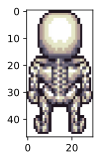

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


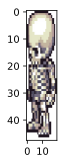

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


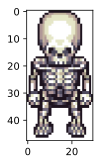

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


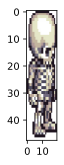

In [10]:
#show(labeled, 50)
clusters = []
# component_sort_dict = {}
#for n in range(ncomponents):
#for n in final_rows[0]['row']:
for n in labeled_sprites[0]:
    raw_inds = np.where(labeled==n)
    rrow, rcol = raw_inds
#     indices = zip(rrow, rcol)
#     indices = sorted(indices, key=lambda x:x[1])
#     indices = sorted(indices, key=lambda x:x[0])
#     least_index = indices[0]
    #component_sort_dict[n] = least_index
    minr, maxr = int(min(rrow)), int(max(rrow))
    minc, maxc = int(min(rcol)), int(max(rcol))
    comp_dict = {}
    comp_dict['index']= n
    comp_dict['row_tup'] = (minr, maxr+1)
    comp_dict['col_tup'] = (minc, maxc+1)
    #comp_dict['point'] = (maxr,maxc)
    comp_dict['point'] = centroid((minr, maxr+1),(minc, maxc+1))
    #comp_dict['point'] = least_index
    #comp_dict['img'] = img[minr:maxr+1,minc:maxc+1]
    #sub_image = img[minr:maxr+1,minc:maxc+1]
    #show(sub_image,50)
    clusters.append(comp_dict)
    
    
#clusters = sorted(clusters, key=lambda k: k['point'][0]) 
#clusters = sorted(clusters, key=lambda k: k['point'][1]) 
#clusters = sorted(clusters, key=lambda k: k['index'])




### POST SORT LOGIC ####
for c in clusters:
    i =c['index']
    topleft, topright = c['row_tup']
    botleft, botright = c['col_tup']
    sub_image = img[topleft:topright,botleft:botright]
    io.imsave(f'tmp/img{i}.png',sub_image)
    #print(c['point'])
    show(transpose(sub_image),20)
        

In [ ]:
#row_label_sets = sorted(row_label_sets, key=lambda k: k['length'], reverse=True)
#print(row_label_sets )
print('-------------------------')
# seen = set()
# max_ind, max_len = -1, 0
# final_rows = []
# for i,r in enumerate(row_label_sets):
#     if r['length'] < max_len:
#         row_set = set(row_label_sets[max_ind]['row'])
#         if bool(seen & row_set):
#             continue
#         else:
#             seen.update(row_set)
#             final_rows.append(row_label_sets[max_ind])
#             max_ind, max_len = -1, 0
#     max_ind, max_len = i, r['length']

            
# set_lengths = {}
# prev_len, max_ind = 0, 0 
# ordering = 0
# for i in range(len(row_label_sets)):
#     current = len(row_label_sets[i])
#     if current < prev_len:
#         set_lengths[ordering] = row_label_sets[max_ind]
#         ordering += 1
#     prev_len=current
#     max_ind = i
# print(set_lengths)
    
#show(labeled, 50)
clusters = []
# component_sort_dict = {}
for n in range(ncomponents):
#for n in final_rows[0]['row']:
    raw_inds = np.where(labeled==n)
    rrow, rcol = raw_inds
#     indices = zip(rrow, rcol)
#     indices = sorted(indices, key=lambda x:x[1])
#     indices = sorted(indices, key=lambda x:x[0])
#     least_index = indices[0]
    #component_sort_dict[n] = least_index
    minr, maxr = int(min(rrow)), int(max(rrow))
    minc, maxc = int(min(rcol)), int(max(rcol))
    comp_dict = {}
    comp_dict['index']= n
    comp_dict['row_tup'] = (minr, maxr+1)
    comp_dict['col_tup'] = (minc, maxc+1)
    #comp_dict['point'] = (maxr,maxc)
    comp_dict['point'] = centroid((minr, maxr+1),(minc, maxc+1))
    #comp_dict['point'] = least_index
    #comp_dict['img'] = img[minr:maxr+1,minc:maxc+1]
    #sub_image = img[minr:maxr+1,minc:maxc+1]
    #show(sub_image,50)
    clusters.append(comp_dict)
    
    
#clusters = sorted(clusters, key=lambda k: k['point'][0]) 
#clusters = sorted(clusters, key=lambda k: k['point'][1]) 
#clusters = sorted(clusters, key=lambda k: k['index'])




### POST SORT LOGIC ####
# for c in clusters[0:20]:
#     print(c['index'])
#     topleft, topright = c['row_tup']
#     botleft, botright = c['col_tup']
#     sub_image = img[topleft:topright,botleft:botright]
#     #io.imsave(f'tmp/img{n}.png',sub_image)
#     #print(c['point'])
#     show(sub_image,50)
        

##### Sub Div stuff ######
def get_diff_list(rows):
    diffrows = [None]
    for i in range(len(rows)-1):
        if rows[i+1]-rows[i] ==1:
            continue
        else:
            if diffrows[-1]!=rows[i]:
                diffrows.append(rows[i])
            diffrows.append(rows[i+1])
    return diffrows[1:]
    
rows = []
for row in range(len(img)):
    num_colors = len(set(list(tuple(x) for x in img[row])))
    if num_colors == 1:
        rows.append(row)
print(rows)

# diffrows = get_diff_list(rows)
# col_dict = {}
# for i in range(len(diffrows)-1):
#     up, down = diffrows[i],diffrows[i+1]
#     for col in range(len(img[0])):
#         num_colors = len(set(list(tuple(x) for x in img[up:down,col])))
#         if num_colors == 1:
#             if (up,down) not in col_dict:
#                 col_dict[(up,down)] = []
#             col_dict[(up,down)].append(col)
    
for rbound in rows:
    img[rbound,:] = 255
    
# for tup,col in col_dict.items():
#     up,down = tup
#     img[up:down,col] = 255

row_dict = {}
for tup in col_dict:
    up,down = tup
    bound_cols = get_diff_list(col_dict[tup])
    for i in range(len(bound_cols)-1):
        left,right = bound_cols[i], bound_cols[i+1]
        for row in range(up,down+1):
            num_colors = len(set(list(tuple(x) for x in img[row,left:right])))
            if num_colors == 1:
                if row not in row_dict:
                    row_dict[row] = []
                row_dict[row] = (left,right)
                #img[row,left:right] = 0

# for row,tup in row_dict.items():
#     left,right = tup
#     img[row,left:right] = 255
show(img,50)